An attempt at building an autoencoder model

# Import the libraries

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
import numpy as np
import os
import cv2
import keras
import random
from keras import layers

# Import the image dataset for training

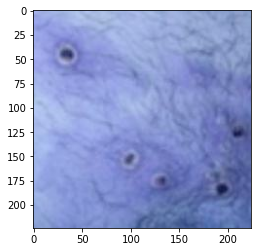

In [62]:
#get the location of the training, testing, and validation images
TRAIN_DATADIR = "C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1/Train"
TEST_DATADIR = "C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1/Test"
VAL_DATADIR = "C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1/Val"

#there are two folders in the train folder
CATEGORIES = ['Monkeypox', 'Others']

#for every image, divide them per category
for category in CATEGORIES:
    path = os.path.join(TRAIN_DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        break
    break

#resize the images for normalizaiton
IMG_SIZE = 112
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [63]:
#define a function for creating a training set
def create_data(DATADIR, data_array):
    for i in range(len(CATEGORIES)):
        category = CATEGORIES[i]
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                data_array.append([img_array, class_num])
            except Exception as e:
                pass

In [64]:
#create a training set
training_data = []
create_data(TRAIN_DATADIR, training_data)

#testing set
testing_data = []
create_data(TEST_DATADIR, testing_data)

#validation set
val_data = []
create_data(VAL_DATADIR, val_data)

In [65]:
#print the length of the all the data
print("Training data:\t\t", len(training_data), "\nTesting data:\t\t", len(testing_data), "\nValidation data:\t", len(val_data))

Training data:		 2142 
Testing data:		 45 
Validation data:	 420


In [66]:
#check the stratification of images for training data
def check_count(data_array):
    count_monkeypox = 0
    count_others = 0
    for image in data_array:
        if image[1] == 0:
            count_monkeypox += 1
        else:
            count_others += 1
    return count_monkeypox, count_others

In [67]:
#print the count for every set of data
count_train = check_count(training_data)
count_test = check_count(testing_data)
count_val = check_count(val_data)
print('Training data\nMonkeypox: {} \t\tOthers: {}'.format(count_train[0], count_train[1]), '\t\tAll:', count_train[0]+count_train[1])
print('\nTesting data\nMonkeypox: {} \t\tOthers: {}'.format(count_test[0], count_test[1]), '\t\tAll:', count_test[0]+count_test[1])
print('\nValidation data\nMonkeypox: {} \t\tOthers: {}'.format(count_val[0], count_val[1]), '\t\tAll:', count_val[0]+count_val[1])

Training data
Monkeypox: 980 		Others: 1162 		All: 2142

Testing data
Monkeypox: 20 		Others: 25 		All: 45

Validation data
Monkeypox: 168 		Others: 252 		All: 420


In [68]:
#shuffle the images
random.shuffle(training_data)

#print out the first 10 images from the shuffle
for sample in training_data[:10]:
    print(sample[1])

1
1
0
1
1
1
1
0
1
1


problem lies here

# Create the structure

In [69]:
#Specify the size of encoded representations or the bottleneck
encoding_dim = 32

#Input image
input_img = keras.Input(shape=(37632,))
#'encoded' is the encoded representation of the input or the bottleneck
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
#'decoded' is the lossy reconstruction of the input
decoded = layers.Dense(37632, activation='sigmoid')(encoded)

#maps the input image to the output layer
autoencoder = keras.Model(input_img, decoded)

# Create a separate encoder model

In [70]:
#maps the input image to the input layer
encoder = keras.Model(input_img, encoded)

# Create a separate decoder model

In [71]:
#encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
#retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
#create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# Train the model

In [72]:
#configure the model to use a per-pixel binary crossentropy loss and the Adam optimizer
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [74]:
training_data.dtype

AttributeError: 'list' object has no attribute 'dtype'

In [73]:
#normalize values between 0 and 1 and flatten the images
training_data = training_data.astype('float32') / 255
testing_data = testing_data.astype('float32') / 255
training_data = training_data.reshape((len(training_data), np.prod(training_data.shape[1:])))
testing_data = testing_data.reshape((len(testing_data), np.prod(testing_data.shape[1:])))
print(training_data.shape)
print(testing_data.shape)
np.max(training_data), np.max(testing_data)

AttributeError: 'list' object has no attribute 'astype'

In [ ]:
#training for 50 epochs
autoencoder.fit(training_data, training_data,
              epochs=10,
              batch_size=256,
              shuffle=True,
              validation_data=(testing_data, testing_data))

# Visualization of reconstructed inputs and encoded representations

In [ ]:
#encode and decode some digits
#note that these are taken from the 'test' set
encoded_imgs = encoder.predict(testing_data)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
#use matplotlib
import matplotlib.pyplot as plt

n=3 #how many images to display
plt.figure(figsize=(20,4))
for i in range (n):
    #display the original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(testing_data[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display the reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(100, 100))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()